<a href="https://colab.research.google.com/github/yeejingzuTUAT/Image-features-of-a-splashing-drop-on-a-solid-surface-extracted-using-a-feedforward-neural-network/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Publication:

Jingzu Yee, Akinori Yamanaka (山中晃徳), and Yoshiyuki Tagawa (田川義之) , "Image features of a splashing drop on a solid surface extracted using a feedforward neural network", Physics of Fluids 34, 013317 (2022) https://doi.org/10.1063/5.0077050

# 1) Setup

In [ ]:
#Setting up Google Colab
!pip install PyDrive
!pip install keras==2.6

In [ ]:
#Importing libraries
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import auth
from google.colab import drive
from google.colab import files
from oauth2client.client import GoogleCredentials

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt

import cv2
import glob
import numpy as np
import pandas as pd
import shutil

from tqdm import tqdm
from zipfile import ZipFile

# 2) Authentication & Choosing Image Types
(Unhide to enter password and choose the type of images: $z_0/2R_0$ and the focus of the image)

In [ ]:
#Google authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Drive = GoogleDrive(gauth)

In [ ]:
#Font designs for figures
from matplotlib.font_manager import FontProperties

fs = 16
font = FontProperties()
font.set_size(fs)
font_leg = FontProperties()
font_leg.set_family('Serif')
font_leg.set_size(12)

In [ ]:
#Set the value of z0/2R0 (0.25, 0.50 or 0.75)
z_2R = 0.50

#Set the focus (whole drop: 1, left lamella: 2, main body: 3, right lamella: 4)
focus = 1

# 3) Load Data

In [ ]:
#Download Data
#https://drive.google.com/file/d/1G0mtIvH6I0XyEUFjIfhnvPrtR-SsDc8U/view?usp=sharing
if os.path.exists('PoF_Yee_2022_data.zip') == 0:
    download = Drive.CreateFile({'id': '1G0mtIvH6I0XyEUFjIfhnvPrtR-SsDc8U'})
    download.GetContentFile('PoF_Yee_2022_data.zip')
    !unzip PoF_Yee_2022_data.zip

In [ ]:
#Load id, H, U, and label
M_data = pd.read_csv('data/data.csv')
M_id = M_data['id'].values
M_H = M_data['H'].values
M_U = M_data['U'].values
M_label = M_data['label'].values

In [ ]:
#Load images
if z_2R == 0.25:
    drop = 'data/drop_025_20210913/'
elif z_2R == 0.50:
    drop = 'data/drop_050_20210630/'
elif z_2R == 0.75:
    drop = 'data/drop_075_20210913/'
else:
    del drop

data_image = []
view_data_image = []
for i in tqdm(range(M_id.shape[0])):
    image = cv2.imread(drop+M_id[i].astype('str')+'.tif',0)
    print(type(image))
    if focus == 1:
        image = image
    elif focus == 2:
        image = image[:,0:213] #x/2R = -1.8 to -0.6
    elif focus == 3:
        image = image[:,213:426] #x/2R = -0.6 to 0.6
    elif focus == 4:
        image = image[:,426:640] #x/2R = 0.6 to 1.8
    else:
        del image
    img = image/255
    view_data_image.append(img)
    img = img.reshape((image.shape[0]*image.shape[1]))
    data_image.append(img)

img_h = image.shape[0]
img_w = image.shape[1]
M_imgs = np.array(data_image)

In [ ]:
#Combining all the data into a masterlist
M_all = []
for i in range(M_H.shape[0]):
    M_all_append = [M_id[i],M_H[i],M_U[i],M_label[i],M_imgs[i]]
    M_all.append(M_all_append)

# 4) Preparation for Fivefold Cross Validation

In [ ]:
#defining a function for train_ans for comb_k
def comb(k):
    k1 = 2 * k
    train_pc = 0.8
    tp = int(((1 - train_pc) * 10 ) - 2)
    k_all = list(range(k1-1,k1 + tp + 1))
    k_all = [el%10 for el in k_all]
    
    train_out = []
    test_out = []
    
    for i in range(len(M_all)):
        kk = M_all[i][0]%10
        if np.sum(kk == k_all) == 1:
            test_out.append(M_all[i])
        else:
            train_out.append(M_all[i])
    
    return train_out, test_out

In [ ]:
#Preparing data for each combination
id_train = []
id_test = []
H_train = []
H_test = []
U_train = []
U_test = []
y_train = []
y_test = []
x_train = []
x_test = []

for i in range(1,6):
  id_train.append(np.array([el[0] for el in comb(i)[0]]))
  id_test.append(np.array([el[0] for el in comb(i)[1]]))
  H_train.append(np.array([el[1] for el in comb(i)[0]]))
  H_test.append(np.array([el[1] for el in comb(i)[1]]))
  U_train.append(np.array([el[2] for el in comb(i)[0]]))
  U_test.append(np.array([el[2] for el in comb(i)[1]]))
  y_train.append(to_categorical([el[3] for el in comb(i)[0]]))
  y_test.append(to_categorical([el[3] for el in comb(i)[1]]))
  x_train.append(np.array([el[4] for el in comb(i)[0]]))
  x_test.append(np.array([el[4] for el in comb(i)[1]]))

# 5) Check Prepared Data

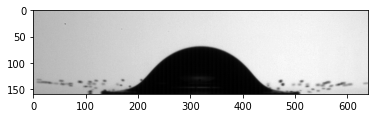

Label = 136
(201, 102400)


In [ ]:
i = np.random.choice(len(view_data_image))
plt.imshow(view_data_image[i].squeeze(), cmap=plt.cm.gray)
plt.show()
print('Label = ' + str(i+1))
print(x_train[0].shape)

In [ ]:
#Check the Number of Data
path_result = 'result/'
if os.path.exists(path_result) == 1:
    shutil.rmtree(path_result)
os.mkdir(path_result)

path_data_num = path_result + 'DataNum/'
os.mkdir(path_data_num)

for comb in range(1,6):
    k = comb - 1
    
    count_df = pd.DataFrame(columns=['Type','Spl.','Nonspl.', 'Tot.'])
    count1 = np.count_nonzero(y_train[k][:,1] == 1)
    count111 = H_train[k].shape[0]
    count11 = count111 - count1
    
    count2 = np.count_nonzero(y_test[k][:,1] == 1)
    count222 = H_test[k].shape[0]
    count22 = count222 - count2
    
    count_df.loc[0] = ['Train', count1, count11, count111]
    count_df.loc[1] = ['Test',count2, count22, count222]
    count_df.loc[2] = ['Tot.', count1+count2, count11+count22, 
                       count111+count222]
    
    count_name = path_data_num+'DataNum_comb'+str(comb)+'.csv'
    count_df.to_csv(count_name, header=True, index=False)
    
    print('Comb. ',comb,':')
    print(count_df)
    print('\n')

Comb.  1 :
    Type Spl. Nonspl. Tot.
0  Train  114      87  201
1   Test   27      21   48
2   Tot.  141     108  249


Comb.  2 :
    Type Spl. Nonspl. Tot.
0  Train  112      86  198
1   Test   29      22   51
2   Tot.  141     108  249


Comb.  3 :
    Type Spl. Nonspl. Tot.
0  Train  113      85  198
1   Test   28      23   51
2   Tot.  141     108  249


Comb.  4 :
    Type Spl. Nonspl. Tot.
0  Train  114      85  199
1   Test   27      23   50
2   Tot.  141     108  249


Comb.  5 :
    Type Spl. Nonspl. Tot.
0  Train  111      89  200
1   Test   30      19   49
2   Tot.  141     108  249




# 6) Feedforward Neural Network and Hyperparameter Tuning

In [ ]:
#Defining the Model Structure
model = Sequential()
model.add(Dense(2, activation = 'sigmoid', input_shape = (img_h*img_w,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 204802    
Total params: 204,802
Trainable params: 204,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Hyperparameter tuning
epoch = 10000
batch = 32
split = 0.2
LR = 0.0005
Mmntm = 0.9
ptnc = 50
#(Recommended: batch = 32, LR = 5e-5 to 5e-4 , Mmntm = 0.9)

#Define the callback list & sgd
callback = [keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0,
    patience=ptnc, restore_best_weights=True)]

opt = optimizers.SGD(learning_rate = LR, momentum = Mmntm)

In [ ]:
#Compiling the model
path_model = path_result + 'models/'
if os.path.exists(path_model) == 0:
    os.mkdir(path_model)

if os.path.exists(path_model+'model_ini.h5') == 1:
    print(path_model+'model_ini.h5')
    model = load_model(path_model+'model_ini.h5')
else:
    print("Doesn't exist")

model.compile(optimizer=opt,loss ='binary_crossentropy', metrics=['acc'])
model.save(path_model+'model_ini.h5')

Doesn't exist


In [ ]:
#Initial weights & biases
w_ini = model.layers[0].get_weights()[0]
b_ini = model.layers[0].get_weights()[1]

# 7) Training for All Combinations

(Skip this step if trained models are available for visualization)

In [ ]:
#Training the model for comb1
model1 = load_model(path_model+'model_ini.h5')
history1 = model1.fit(x_train[0], y_train[0], batch_size = batch,
                      epochs = epoch, verbose = 2, validation_split = split,
                      callbacks = callback)
model1.save(path_model+'model_comb1.h5')

In [ ]:
#Training the model for comb2
model2 = load_model(path_model+'model_ini.h5')
history2 = model2.fit(x_train[1], y_train[1], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model2.save(path_model+'model_comb2.h5')

In [ ]:
#Training the model for comb3
model3 = load_model(path_model+'model_ini.h5')
history3 = model3.fit(x_train[2], y_train[2], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model3.save(path_model+'model_comb3.h5')

In [ ]:
#Training the model for comb4
model4 = load_model(path_model+'model_ini.h5')
history4 = model4.fit(x_train[3], y_train[3], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model4.save(path_model+'model_comb4.h5')

In [ ]:
#Training the model for comb5
model5 = load_model(path_model+'model_ini.h5')
history5 = model5.fit(x_train[4], y_train[4], batch_size = batch,
                      epochs = epoch, verbose = 0, validation_split = split,
                      callbacks = callback)
model5.save(path_model+'model_comb5.h5')

# 8) Load/Save Trained Models

In [ ]:
model1 = load_model(path_model+'model_comb1.h5')
model2 = load_model(path_model+'model_comb2.h5')
model3 = load_model(path_model+'model_comb3.h5')
model4 = load_model(path_model+'model_comb4.h5')
model5 = load_model(path_model+'model_comb5.h5')

In [ ]:
#compiling all trained models in model_all
model_all = []
model_all.append(model1)
model_all.append(model2)
model_all.append(model3)
model_all.append(model4)
model_all.append(model5)

# 9) Loss & Accuracy

## 9.1) Define plot functions

In [ ]:
#save training history
path_log = path_result + 'train_log/'
if os.path.exists(path_log) == 0:
    os.mkdir(path_log)

if 'history1' in globals():
    for i in range(1,6):
        k = globals()['history'+str(i)]
        log = pd.DataFrame(k.history)
        log_name = path_log+'log_comb'+str(i)+'.csv'
        log.to_csv(log_name, header=True, index=False)

In [ ]:
#Plotting loss & accuracy for one combination
def plot_loss_acc(comb):
    log_name = path_log+'log_comb'+str(i)+'.csv'
    k = pd.read_csv(log_name)
    
    train_loss = k['loss']
    val_loss = k['val_loss']
    train_acc = k['acc']
    val_acc = k['val_acc']
    
    epoch_plt = list(range(1, len(val_loss) + 1))
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(111)
    lns1 = ax1.plot(epoch_plt, train_loss, '-r', 
                    label = 'traning loss')
    lns2 = ax1.plot(epoch_plt, val_loss,
                    label = 'validation loss', c='tab:orange')
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    ax2 = ax1.twinx()
    lns3 = ax2.plot(epoch_plt, train_acc, '-b',
                    label = 'training accuracy')
    lns4 = ax2.plot(epoch_plt, val_acc, '-g',
                    label = 'validation accuracy')
    plt.yticks(fontsize=fs)
    
    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    leg = ax1.legend(lns, labs, loc=5, prop=font_leg)
    
    ax1.set_xlabel('Epoch', fontproperties=font)
    ax1.set_ylabel('Loss', fontproperties=font)
    ax2.set_ylabel('Accuracy', fontproperties=font, rotation=-90, labelpad=15)
    ax1.set_ylim(-0.05,1.05)
    ax2.set_ylim(-0.05,1.05)
    
    title_loss_acc = 'Combination ' + str(comb)
    plt.title(title_loss_acc, fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)

In [ ]:
#Plotting loss
def plot_loss(comb):
    
    log_name = path_log+'log_comb'+str(comb)+'.csv'
    k = pd.read_csv(log_name)
    
    train_loss = k['loss']
    val_loss = k['val_loss']
    
    label_train_loss = 'Comb. ' + str(comb) + ' (train.)'
    label_val_loss = 'Comb. ' + str(comb) + ' (val.)'
    
    epoch_plt = list(range(1, len(val_loss) + 1))
    
    #Taking only every 50th step
    epoch_plt = np.array(epoch_plt)
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    epoch_plt = epoch_plt[::50]
    train_loss = train_loss[::50]
    val_loss = val_loss[::50]
    
    sameColor = next(colorIter)

    plt.plot(epoch_plt, train_loss, 'o--', c = sameColor,# mfc = 'None',
             label = label_train_loss)
    plt.plot(epoch_plt, val_loss, '^:', c = sameColor,# mfc = 'None', 
             label = label_val_loss)
    plt.ylim(-0.05,1.05)
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('Epoch [-]', fontproperties=font)
    plt.ylabel('Loss [-]', fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)
    leg = plt.legend(loc=0, prop=font_leg, ncol=2, frameon=True)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting accuracy
def plot_acc(comb):
    
    log_name = path_log+'log_comb'+str(comb)+'.csv'
    k = pd.read_csv(log_name)
    
    train_acc = k['acc']
    val_acc = k['val_acc']
    
    label_train_acc = 'Comb. ' + str(comb) + ' (train.)'
    label_val_acc = 'Comb. ' + str(comb) + ' (val.)'
    
    epoch_plt = list(range(1, len(val_acc) + 1))

    #Taking only every 50th step
    epoch_plt = np.array(epoch_plt)
    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)
    epoch_plt = epoch_plt[::50]
    train_acc = train_acc[::50]
    val_acc = val_acc[::50]

    sameColor = next(colorIter)

    plt.plot(epoch_plt, train_acc, 'o--', c = sameColor,# mfc = 'None',
             label = label_train_acc)
    plt.plot(epoch_plt, val_acc, '^:', c = sameColor,# mfc = 'None', 
             label = label_val_acc)
    # plt.xlim(-10,max(epoch_plt)+10)
    plt.ylim(-0.05,1.05)
    
    # plt.xticks(np.arange(0,2001, step = 500),fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('Epoch [-]', fontproperties=font)
    plt.ylabel('Accuracy [-]', fontproperties=font)
    # plt.title('Accuracy vs. Epoch', fontproperties=font)
    plt.grid(linestyle='solid', alpha=0.5)
    leg = plt.legend(loc=0, prop=font_leg, ncol=2, frameon=True)
    leg.get_frame().set_edgecolor('black')

## 9.2) Plots

In [ ]:
path_LossAcc = path_result + 'LossAcc/'
if os.path.exists(path_LossAcc) == 0:
    os.mkdir(path_LossAcc)

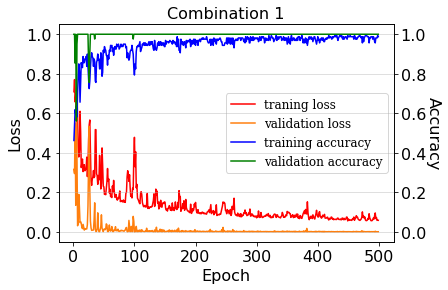

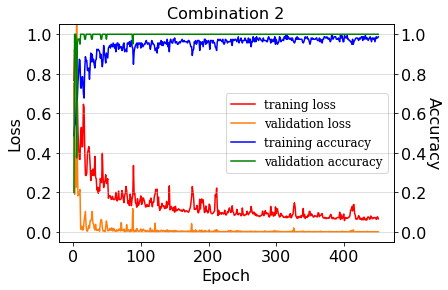

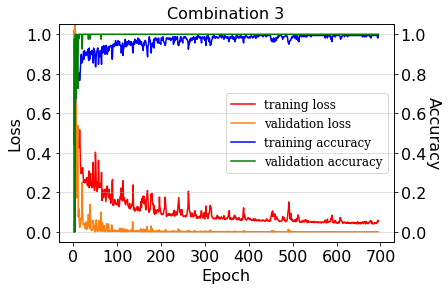

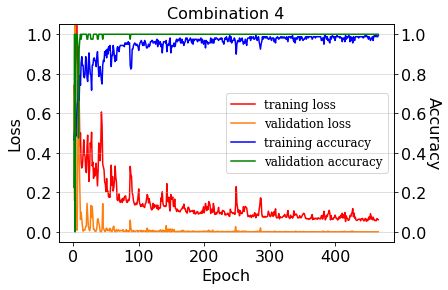

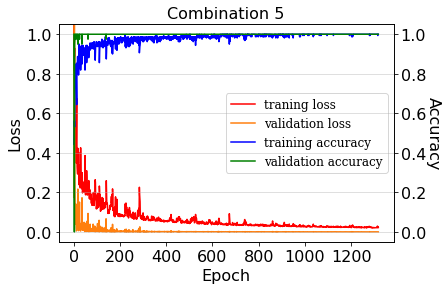

In [ ]:
for i in range(1,6):
    plot_loss_acc(i)
    plt.savefig(path_LossAcc+'LossAcc_Comb%d.png'%i, dpi=300, bbox_inches='tight')
    plt.show()

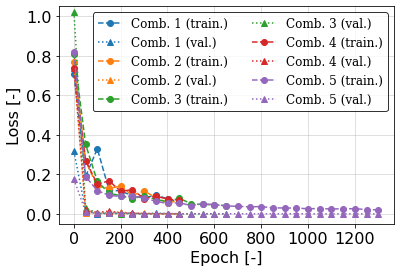

In [ ]:
colorIter = iter(
    ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'))

for i in range(1,6):
    plot_loss(i)
    plt.savefig(path_LossAcc+'CombAll_Loss.png', dpi=300, bbox_inches='tight')

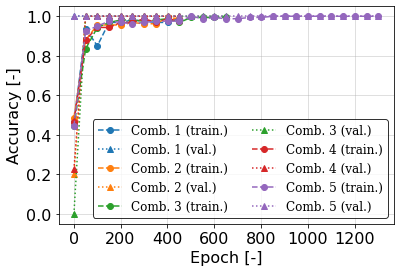

In [ ]:
#colorIter has to be redefined after plotting 'CombAll_Loss.png'
colorIter = iter(
    ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'))

for i in range(1,6):
    plot_acc(i)
    plt.savefig(path_LossAcc+'CombAll_Acc.png', dpi=300, bbox_inches='tight')

# 10) Testing

## 10.1) Define functions

In [ ]:
path_test = path_result + 'test/'

if os.path.exists(path_test) == 0:
  os.mkdir(path_test)

In [ ]:
#Compiling the probability & prediction of all combinations
prob = []
pred = []

for i in range(1,6):
    i = i - 1
    prob.append(model_all[i].predict(x_test[i]))
    pred.append(np.argmax(model_all[i].predict(x_test[i]), axis=-1))

In [ ]:
#Define function for test result of comb_k
def result_test(comb):
    k = comb - 1
    
    #Checking the prediction with answer
    TF = []
    for i in range(pred[k].shape[0]):
        if pred[k][i] == y_test[k][i,1]:
            tfpn = 'T'
        else:
            tfpn = 'F'
        
        if pred[k][i] == 1:
            tfpn = tfpn + 'P'
        else:
            tfpn = tfpn + 'N'
        TF.append(tfpn)
    
    TF = np.array(TF)
  
    #Saving test result on a df
    result_test = pd.DataFrame(H_test[k][:], columns = ['H'])
    result_test['id'] = id_test[k][:]
    result_test['prob.'] = np.round(prob[k][:,1],2)
    result_test['pred.'] = pred[k]
    result_test['ans.'] = y_test[k][:,1].astype(int)
    result_test['T/F'] = TF

    result_test_name = path_test+'test_comb'+str(comb)+'.csv'
    result_test.to_csv(result_test_name, header=True, index=False)
  
    #Counting correct/wrong prediction
    TP = np.count_nonzero(TF == 'TP')
    TN = np.count_nonzero(TF == 'TN')
    Total_P = np.count_nonzero(y_test[k][:,1] == 1)
    Total_N = np.count_nonzero(y_test[k][:,1] == 0)
    Correct = TP + TN
    TP_pc = int(TP/Total_P*100)
    TN_pc = int(TN/Total_N*100)
    Correct_pc = int(Correct/TF.shape[0]*100)
    TP_frac = str(TP)+'/'+str(Total_P)
    TN_frac = str(TN)+'/'+str(Total_N)
    Correct_frac = str(Correct)+'/'+str(TF.shape[0])
    
    TPTN.append([comb, TP_frac, TP_pc, TN_frac, TN_pc, Correct_frac,Correct_pc])
    
    return result_test

In [ ]:
#Test result for all combinations
result_test_all = []
TPTN = []

for i in range(1,6):
    result_test_all.append(result_test(i))

## 10.2) Test Results

In [ ]:
TPTN_df = pd.DataFrame(columns=['Comb','Spl.', 'Spl. (%)', 'Nonspl.', 
                                'Nonspl. (%)', 'Tot.','Tot. (%)'])

for i in range(len(TPTN)):
    TPTN_df.loc[i] = TPTN[i]

TPTN_df.to_csv(path_test+'test_combAll.csv', header=True, index=False)
TPTN_df

,Comb,Spl.,Spl. (%),Nonspl.,Nonspl. (%),Tot.,Tot. (%)
0,1,27/27,100,21/21,100,48/48,100
1,2,29/29,100,22/22,100,51/51,100
2,3,26/28,92,22/23,95,48/51,94
3,4,26/27,96,23/23,100,49/50,98
4,5,28/30,93,19/19,100,47/49,95


# 11) Visualization


## 11.1) Extraction and Calculation

In [ ]:
#Extracting the weights & biases for all combinations
w_train = []
b_train = []

for i in range(5):
    w_train.append(
        model_all[i].layers[0].get_weights()[0])
    b_train.append(
        model_all[i].layers[0].get_weights()[1])

In [ ]:
#Calculating W1s, q, q1, q2 for all combinations
Ws = []
q_out = []
y_pred = []

for i in range(5):
    Ws.append(np.dot(x_test[i],w_train[i]))
    q_out.append(Ws[i] + b_train[i])
    y_pred.append(1/(1+np.exp(-q_out[i])))

## 11.2) Weight $\mathbf{W}$

### 11.2.1) Initial weight

0


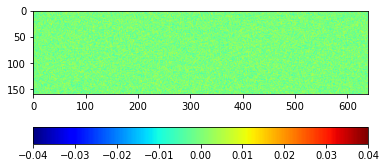

1


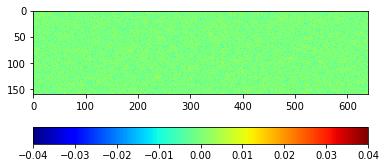

In [ ]:
#Visualization of the initial weight
path_w_ini = path_result+'w_ini/'
if os.path.exists(path_w_ini) == 0:
    os.mkdir(path_w_ini)

w_max = 0.04
w_min = - w_max

for i in range(w_ini.shape[1]):
    print(i)
    f = w_ini[:,i]
    f_im = f.reshape((img_h, img_w))
    matplotlib.image.imsave(path_w_ini+'w_ini_n%d.png'%(i+1),
                            f_im, vmin=w_min, vmax=w_max, cmap='jet')
    
    fig = plt.figure()
    im = plt.imshow(f_im,'jet',vmin=w_min,vmax=w_max)
    fig.colorbar(im, orientation='horizontal')
    plt.show()

### 11.2.2) Trained weight

In [ ]:
#Check max and min values to ensure that colormap is suitably scaled
for i in range(5):
  print(np.max(w_train[i]))
  print(np.min(w_train[i]))

0.049340826
-0.047809005
0.04154589
-0.040295247
0.054113247
-0.05063409
0.046175208
-0.044328865
0.06406129
-0.063366145


In [ ]:
#Visualization of the weight
def view_weight(comb):
    k = comb - 1
    
    w_max = 0.04
    w_min = - w_max
    
    path_w_train = path_result+'w_train/'
    if os.path.exists(path_w_train) == 0:
        os.mkdir(path_w_train)

    print('Comb',comb)

    for i in range(w_train[k].shape[1]):
        print(i+1)
        path_w_comb = path_w_train+'w_comb'+str(comb)+'/'
    
        if os.path.exists(path_w_comb) == 0:
            os.mkdir(path_w_comb)
    
        f = w_train[k][:,i]
        f_im = f.reshape((img_h, img_w))
        matplotlib.image.imsave(
            path_w_comb+'w_comb'+str(comb)+'_n'+str(i+1)+'.png',
            f_im, cmap='jet', vmin=w_min, vmax=w_max)
    
        fig = plt.figure()
        im = plt.imshow(f_im,'jet',vmin=w_min,vmax=w_max)
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        fig.colorbar(im, orientation='horizontal')
    
        plt.show()

Comb 1
1


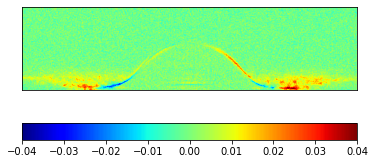

2


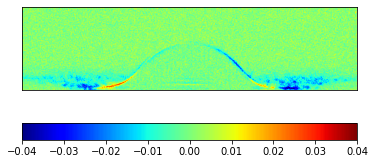

Comb 2
1


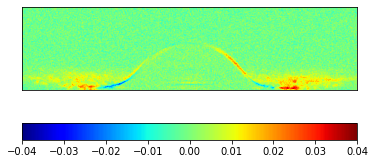

2


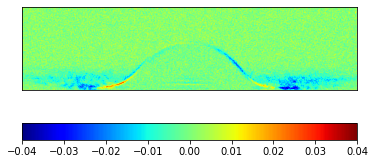

Comb 3
1


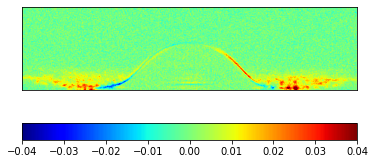

2


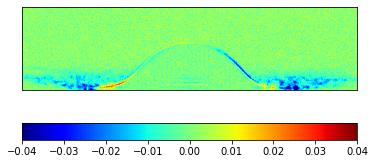

Comb 4
1


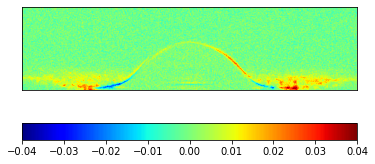

2


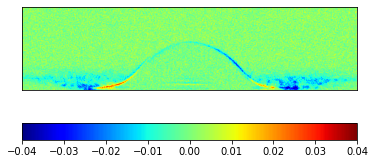

Comb 5
1


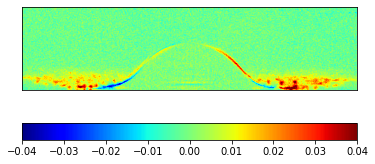

2


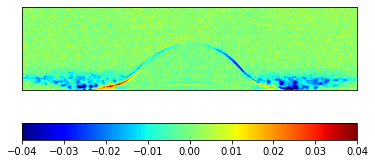

In [ ]:
for i in range(1,6):
    view_weight(i)

## 11.3) Bias $\mathbf{b}$

In [ ]:
path_bias = path_result + 'bias/'

if os.path.exists(path_bias) == 0:
    os.mkdir(path_bias)

bias_df = pd.DataFrame(columns=['Comb','b2_Spl.','b1_Nonspl.', 'min |qout|'])

for comb in range(1,6):
    k = comb - 1
    bias_df.loc[k] = [str(comb), '%.4f'%b_train[k][1], '%.4f'%b_train[k][0], 
                      '%.4f'%np.min(abs(q_out[k]))]

bias_df.loc[6] = ['Initial', '%.4f'%b_ini[1], '%.4f'%b_ini[0], 'N/A']

bias_df.to_csv(path_bias+'bias_combAll.csv', header=True, index=False)
bias_df

,Comb,b2_Spl.,b1_Nonspl.,min |qout|
0,1,0.0032,-0.0032,0.5772
1,2,0.0028,-0.0028,0.0018
2,3,0.0029,-0.0029,0.0130
3,4,0.0031,-0.0031,0.0770
4,5,0.0053,-0.0053,0.6445
6,Initial,0.0000,0.0000,N/A


## 11.4) $\mathbf{Q} = \mathbf{w}_i \circ \mathbf{s}_\mathrm{in}^\top$

In [ ]:
#Visualization of Ws
for sf in range(2):
    for comb in range(1,6):
        k = comb - 1
    
        path_Ws = path_result+'Ws/'
        if os.path.exists(path_Ws) == 0:
            os.mkdir(path_Ws)
    
        path_Ws_sf = path_Ws+'n'+str(sf)+'/'
        if os.path.exists(path_Ws_sf) == 0:
            os.mkdir(path_Ws_sf)
    
        path_Ws_comb = path_Ws_sf+'Ws_comb'+str(comb)+'_n'+str(sf)+'/'
        if os.path.exists(path_Ws_comb) == 0:
            os.mkdir(path_Ws_comb)

        Ws_max = 0.04
        Ws_min = - Ws_max
    
        for i in range(x_test[k].shape[0]):
            f = x_test[k][i]*w_train[k][:,sf]
            f_im = f.reshape((img_h, img_w))
            f_im_name = \
            path_Ws_comb+'Ws_comb'+str(comb)+'_n'+str(sf)+'_'+str(id_test[k][i])+'.png'
            matplotlib.image.imsave(f_im_name, f_im, 
                                    vmin=Ws_min, vmax=Ws_max, cmap='jet')
        # print(i+1)

## 11.5) $q_{out}$ and $y_{pred}$

### 11.5.1) Define functions

In [ ]:
path_qout_ypred = path_result+'qout_ypred/'

if os.path.exists(path_qout_ypred) == 0:
    os.mkdir(path_qout_ypred)

In [ ]:
#Listing down the calculated values
def csv_qout_ypred(comb):
    k = comb - 1
    
    cqy = np.array(Ws[k])
    cqy[cqy==0] = np.nan
    
    # cqy1 = np.array(q_out[k])
    
    #Creating test_result file
    cqy_df = pd.DataFrame(H_test[k][:], columns = ['H'])
    cqy_df['id'] = id_test[k][:]
    cqy_df['U'] = np.round(U_test[k][:],2)
    
    for i in range(w_train[k].shape[1]):
        cqy_df['Ws%d'%(i+1)] = np.round(cqy[:,i],4)
    
    for i in range(w_train[k].shape[1]):
        cqy_df['qout%d'%(i+1)] = np.round(cqy[:,i],4)
    
    cqy_df['ypred_Nonspl.'] = np.round(y_pred[k][:,0],2)
    cqy_df['ypred_Spl'] = np.round(y_pred[k][:,1],2)
    cqy_df['prob.'] = np.round(prob[k][:,1],2)
    cqy_df['pred.'] = pred[k]
    cqy_df['ans.'] = y_test[k][:,1].astype(int)
    cqy_df['T/F'] = result_test_all[k]['T/F']
    
    path_cqy = path_qout_ypred+'csv/'
    if os.path.exists(path_cqy) == 0:
        os.mkdir(path_cqy)
        
    cqy_name = path_cqy+'csv_comb'+str(comb)+'.csv'
    cqy_df.to_csv(cqy_name, header=True, index=False)
    
    return cqy_df

In [ ]:
#Plotting q_out vs H
def plot_q_outvH_new(comb):
    k = comb - 1
    q_out_plt = q_out[k][:,1]
    H_plt = cqy_all[k]['H'].values
    y_max = 25.1
    y_min = -15
    y_step = 5

    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(q_out_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(q_out_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(q_out_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(q_out_plt[i])
    
    lin_reg = LinearRegression()
    lin_reg.fit(H_plt.reshape(-1,1), q_out_plt)
    lin_reg.intercept_, lin_reg.coef_
    
    q_out_plt_predict = lin_reg.predict(H_plt.reshape(-1,1))
    MSE = mean_squared_error(q_out_plt,q_out_plt_predict)
    
    
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([0,100],[0,0],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    
    
    if np.max(q_out_plt) > np.max(q_out_plt_predict):
        q_outvH_max = np.max(q_out_plt)
    else:
        q_outvH_max = np.max(q_out_plt_predict)
    
    if np.min(q_out_plt) < np.min(q_out_plt_predict):
        q_outvH_min = np.min(q_out_plt)
    else:
        q_outvH_min = np.min(q_out_plt_predict)

    plt.fill_between([19,23], -100, 100, color='0.95',
                     label='Splashing Transition')
    
    plt.xlim([0,62])
    plt.ylim([y_min,y_max])
    
    plt.xticks(np.arange(0,65, step = 5),fontsize=fs)
    plt.yticks(np.arange(y_min,y_max, step = y_step),fontsize=fs)
    plt.xlabel('$H~[\mathrm{cm}]$', fontproperties=font)
    plt.ylabel('$q_{out}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Splash Probability vs H
def plot_prob_spl(comb):
    k = comb - 1
    prob_plt = prob[k][:,1]
    H_plt = cqy_all[k]['H'].values
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',
             fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',
             fillstyle='none')
    plt.plot([-5,65],[0.5,0.5],ls='--',c='black', 
             label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',
             fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',
             fillstyle='none')
    plt.fill_between([19,23], -2, 2, color='0.95', label='Splashing Transition')

    plt.xlim([0,62])
    plt.ylim([-0.05,1.05])
    
    plt.xticks(np.arange(0,65, step = 5),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$H~[\mathrm{cm}]$', fontproperties=font)
    plt.ylabel('$y_{pred}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

In [ ]:
#Plotting Spread Probability vs H
def plot_prob_spr(comb):
    k = comb - 1
    prob_plt = prob[k][:,0]
    H_plt = cqy_all[k]['H'].values
    
    TN = []
    TP = []
    FN = []
    FP = []
    H_TN = []
    H_TP = []
    H_FN = []
    H_FP = []

    TF_plt = cqy_all[k]['T/F']
    for i in range(len(cqy_all[k]['T/F'])):
        if TF_plt[i] == 'TN':
            H_TN.append(H_plt[i])
            TN.append(prob_plt[i])
        elif TF_plt[i] == 'TP':
            H_TP.append(H_plt[i])
            TP.append(prob_plt[i])
        elif TF_plt[i] == 'FN':
            H_FN.append(H_plt[i])
            FN.append(prob_plt[i])
        elif TF_plt[i] == 'FP':
            H_FP.append(H_plt[i])
            FP.append(prob_plt[i])
    
    label_prob = 'Comb_' + str(comb)
    plt.plot(H_TP,TP, 'o', c='blue', label = 'Splash. (Correct)',fillstyle='none')
    plt.plot(H_TN,TN, 'o', c='green', label = 'Nonsplash. (Correct)',fillstyle='none')
    plt.plot([-5,65],[0.5,0.5],ls='--',c='black', label='Classification Threshold')
    plt.plot(H_FN,FN, 'x', c='red', label = 'Splash. (Wrong)',fillstyle='none')
    plt.plot(H_FP,FP, 'x', c='orange', label = 'Nonsplash. (Wrong)',fillstyle='none')
    plt.fill_between([19,23], -2, 2, color='0.95', label='Splashing Transition')
    
    plt.xlim([0,62])
    plt.ylim([-0.05,1.02])
    
    plt.xticks(np.arange(0,65, step = 5),fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel('$H~[\mathrm{cm}]$', fontproperties=font)
    plt.ylabel('$y_{pred}$ [-]', fontproperties=font)
    leg = plt.legend(loc=9, bbox_to_anchor=(0.5, 1.35), ncol=2, prop=font_leg, 
                     frameon=True)
    plt.grid(linestyle='solid', alpha=0.5)
    leg.get_frame().set_edgecolor('black')

### 11.5.2) CSV

In [ ]:
#Combine all csv files
cqy_all = []

for i in range(1,6):
    cqy_all.append(csv_qout_ypred(i))

In [ ]:
cqy_all[0]

,H,id,U,Ws1,Ws2,qout1,qout2,ypred_Nonspl.,ypred_Spl,prob.,pred.,ans.,T/F
0,4,1,0.86,6.0256,-6.0110,6.0256,-6.0110,1.00,0.00,0.00,0,0,TN
1,4,2,0.83,6.5717,-6.6302,6.5717,-6.6302,1.00,0.00,0.00,0,0,TN
2,4,11,0.85,6.2476,-6.1925,6.2476,-6.1925,1.00,0.00,0.00,0,0,TN
3,4,12,0.84,6.2682,-6.2065,6.2682,-6.2065,1.00,0.00,0.00,0,0,TN
4,8,21,1.24,3.2307,-3.2383,3.2307,-3.2383,0.96,0.04,0.04,0,0,TN
5,8,22,1.25,4.2159,-4.2143,4.2159,-4.2143,0.99,0.01,0.01,0,0,TN
6,8,31,1.23,3.5717,-3.5476,3.5717,-3.5476,0.97,0.03,0.03,0,0,TN
7,8,32,1.26,2.7620,-2.7554,2.7620,-2.7554,0.94,0.06,0.06,0,0,TN
8,12,41,1.50,3.4268,-3.4187,3.4268,-3.4187,0.97,0.03,0.03,0,0,TN
9,12,51,1.49,3.0617,-3.0880,3.0617,-3.0880,0.96,0.04,0.04,0,0,TN


### 11.5.3) Plots against Impact Height

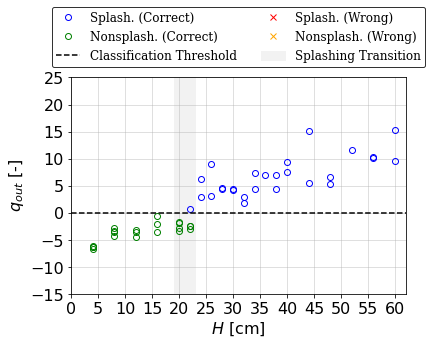

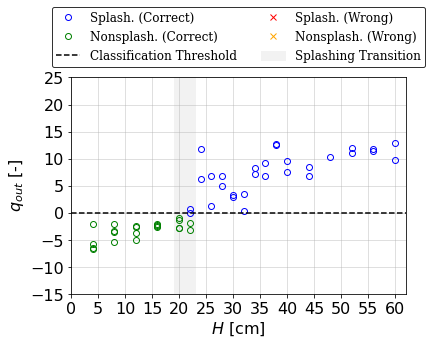

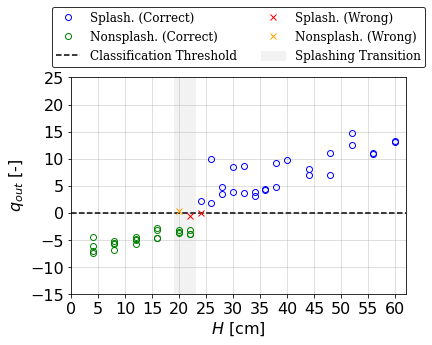

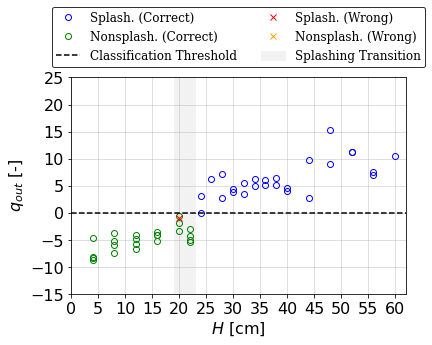

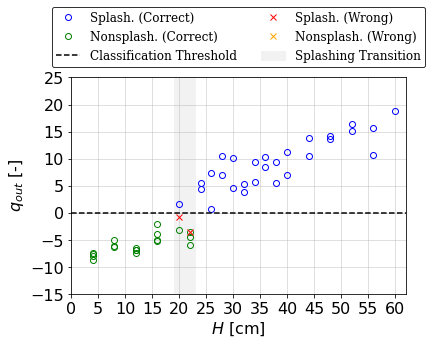

In [ ]:
#Plot q2 vs H for all combinations
path_qout = path_qout_ypred + 'qout/'

if os.path.exists(path_qout) == 0:
  os.mkdir(path_qout)

for i in range(1,6):
  plot_q_outvH_new(i)
  plt.savefig(path_qout+'qout_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

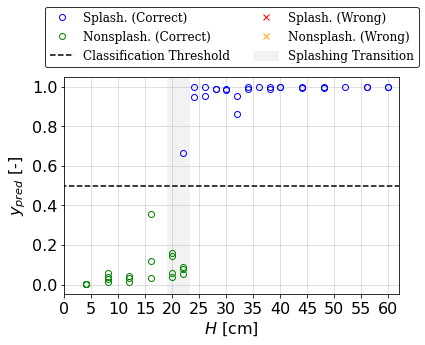

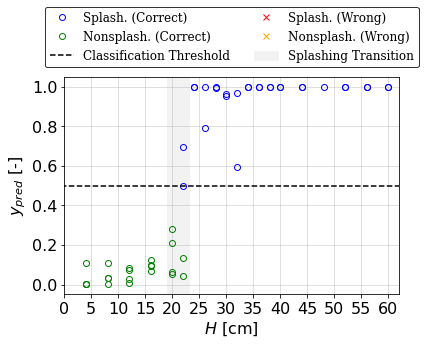

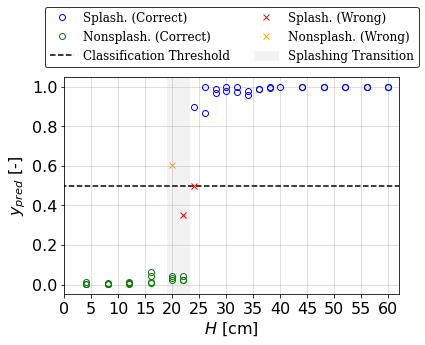

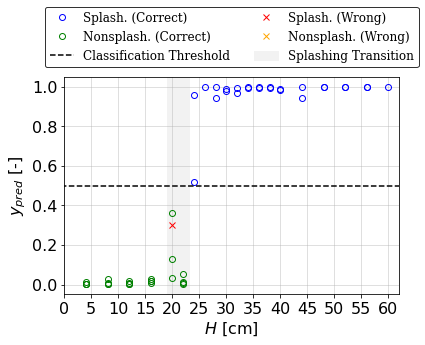

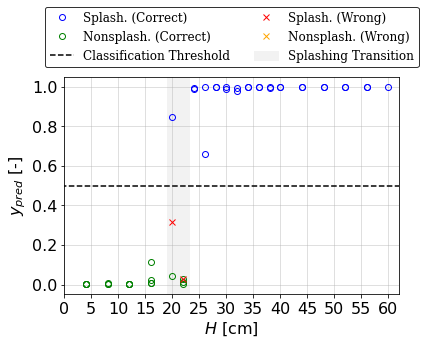

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_spl = path_qout_ypred + 'ypred_spl/'

if os.path.exists(path_ypred_spl) == 0:
  os.mkdir(path_ypred_spl)

for i in range(1,6):
  plot_prob_spl(i)
  plt.savefig(path_ypred_spl+'ypred_spl_Comb%d.png'%i, dpi=300, bbox_inches='tight')
  plt.show()

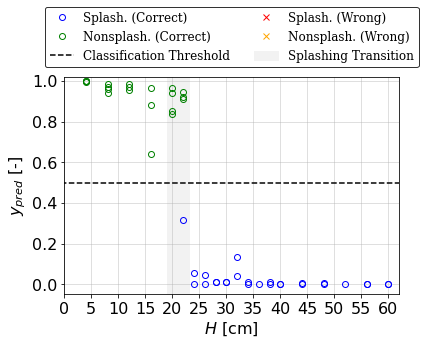

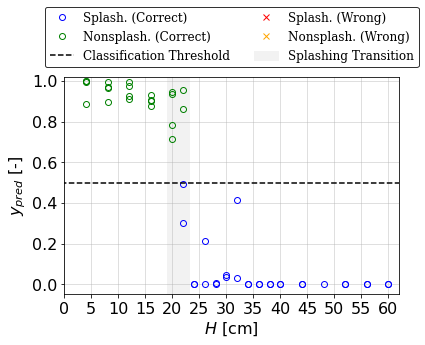

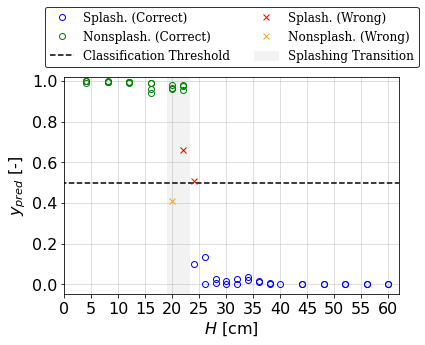

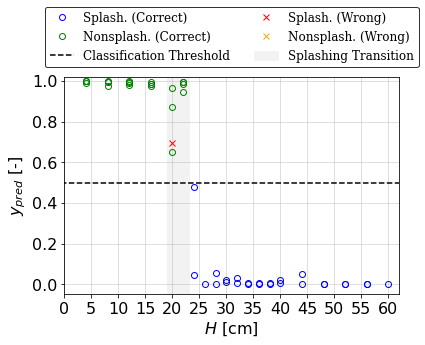

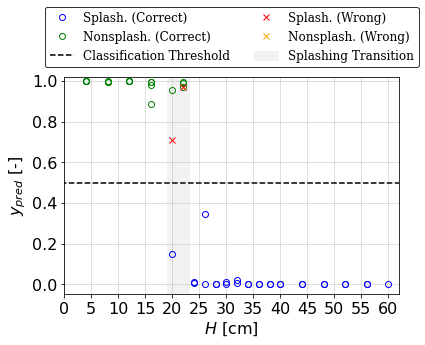

In [ ]:
#Plot splash probability vs H for all combinations
path_ypred_nonspl = path_qout_ypred + 'ypred_nonspl/'

if os.path.exists(path_ypred_nonspl) == 0:
    os.mkdir(path_ypred_nonspl)

for i in range(1,6):
    plot_prob_spr(i)
    plt.savefig(path_ypred_nonspl+'ypred_nonspl_Comb%d.png'%i, 
                dpi=300, bbox_inches='tight')
    plt.show()

# 12) Zip Results
(Please download result.zip manually)

In [ ]:
!zip -r /content/result.zip /content/result